# Análise de Sentimento - Bag of Words Meets Bag of Popcorn

O presente projeto foi realizado para a disciplina Programação para Aprendizagem de Máquina, da pós graduação em Ciência de Dados da Universidade Federal de Pernambuco.

Foi utilizada a base de dados da competição do Kaggle "Bag of words meet bags of popcorns", que contém 50.000 comentários a respeito de filmes no site do IMDb. Os comentários são divididos em 2 grupos: os que foram acompanhados de notas inferiores a 5 estrelas -rotulados como 0- são de comentários com sentimento negativo a respeito do filme, os que foram acompanhados de notas superiores a 7 -rotulados com 1- são comentários com sentimento positivo.

O objetivo do projeto criar um modelo para prever o sentimento do comentário.

## Preparando o ambiente

In [1]:
# Código para o Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [21]:
#Importando bibliotecas relevantes

import pandas as pd #Biblioteca para visualização e manipulação de dataframes
import numpy as np #Biblioteca com métodos matemáticos como geração aleatória de números, algebra linear, etc

#Bibliotecas gráficas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

import nltk #Biblioteca para processamento simbólico e estatístico de linguagem natural
from nltk.corpus import stopwords

#Bibliotecas para avaliação do modelo
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix

from tqdm import tqdm #Biblioteca para visualização do processamos de uma iteração

import string

In [3]:
#Importando base de dados
train = pd.read_csv('labeledTrainData.tsv',sep='\t')

test = pd.read_csv('testData.tsv',sep='\t')

In [4]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
train.shape

(25000, 3)

In [6]:
train.groupby('sentiment').count().id

sentiment
0    12500
1    12500
Name: id, dtype: int64

A base de dados está balanceada, sendo composta por 50% das observações, referentes a um sentimento negativo e os outros 50% a um sentimento positivo.

## Metodologia

O modelo selecionado para o projeto foi o Naive Bayes Classifier. Esse classificador usa a regra de Bayes para prever o output (sentimento positivo ou negativo) do modelo, dadas as informações do review, conforme descrito abaixo:
<br />

$       P(sentimento | palavra) = \frac{P(palavra | sentimento)*P(sentimento)}{P(palavra)}$


Em resumo, será contado o uso de palavras nos reviews resultados em cada sentimento e determinada uma probabilidade de cada palavra estar relacionada a um sentimento negativo ou positivo. 

Um ponto negativo do modelo, importante destacar é que ele não considera a interação entre palavras nem a ordem de aparecimento das mesmas.

## Implementação

Inicialmente, será realizada a preparação dos dados. Nesse processo, as reviews foram separadas em palavras individuais e colocadas em uma lista.

Para o modelo, serão usadas as 2.000 palavras mais comuns.

In [7]:
words = []

#Criando lista com palavras mais frequentes
for n in tqdm([s for s in train.review.str.split(' ')]):
    for w in n:
        if (w != ''):
            words.append(str.lower(w))
        else:
            pass

all_words = nltk.FreqDist(words)
del all_words['']
word_features = list(all_words)[:2000]

100%|██████████| 25000/25000 [00:01<00:00, 14851.39it/s]


É possível observar a lista de palavras mais comuns das reviews no gráfico abaixo. A maioria delas, aparentemente, não passa um sentimento claro em relação ao filme.

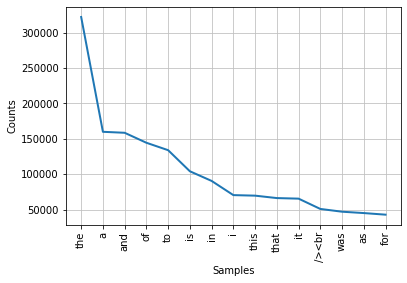

In [8]:
all_words.plot(15)

Para aperfeiçoar o modelo, podemos realizar a limpeza e o tratamento da base de dados.

Nesse processo, excluímos as chamadas stopwords (ou seja, palavras vazias, que o significado não são relevantes para a análise de sentimento do texto). Além disso, todas as palavras foram colocadas em letra minúscula, para que palavras no início de frase não sejam diferenciadas e todas as pontuações também foram excluídas.

In [11]:
#!python -m nltk.downloader all

train['review'] = train['review'].str.lower()
test['review'] = test['review'].str.lower()

stop_words = set(stopwords.words('english')) #Lista de palavras vazias
words = []

#Criando lista com palavras mais frequentes, excluindo palavras vazias
for n in tqdm([s for s in train.review.str.split(' ')]):
    for w in n:
        if (w not in stop_words) & (w != ''):
            words.append(str.lower(w))
        else:
            pass

table = str.maketrans('', '', string.punctuation) 
words = [w.translate(table) for w in words] #excluindo pontuação

all_words = nltk.FreqDist(words)
del all_words['']
del all_words['br']
word_features = list(all_words)[:2000]

100%|██████████| 25000/25000 [00:01<00:00, 14638.80it/s]


Após essa etapa, podemos observar um resultado muito mais compreensível e relevante para o que estamos buscando.

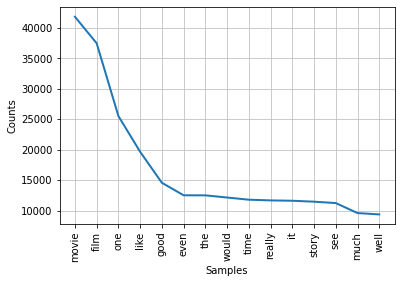

In [12]:
all_words.plot(15)

In [13]:
#Criando arquivo com o formato para o algoritmo
documents = []
for i in tqdm(range(len(train))):
    l=[]
    for s in train.review[i].split(' '):
        l.append(s)
    documents.append((l,train.sentiment[i]))

def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features
  
featuresets = [(document_features(d), c) for (d,c) in documents]

100%|██████████| 25000/25000 [00:01<00:00, 13771.10it/s]


In [14]:
#Dividindo em base de treinamento e teste
train_set, test_set = featuresets[5000:], featuresets[:5000]

In [15]:
# Treinando o modelo
classifier = nltk.NaiveBayesClassifier.train(train_set)

## Avaliação do modelo e conclusão

In [16]:
classifier.show_most_informative_features(10)

Most Informative Features
       contains(unfunny) = True                0 : 1      =     19.4 : 1.0
     contains(pointless) = True                0 : 1      =     14.4 : 1.0
         contains(waste) = True                0 : 1      =     13.8 : 1.0
        contains(poorly) = True                0 : 1      =      9.9 : 1.0
     contains(redeeming) = True                0 : 1      =      9.8 : 1.0
         contains(worst) = True                0 : 1      =      9.6 : 1.0
          contains(lame) = True                0 : 1      =      8.6 : 1.0
   contains(wonderfully) = True                1 : 0      =      8.2 : 1.0
     contains(laughable) = True                0 : 1      =      7.8 : 1.0
   contains(beautifully) = True                1 : 0      =      6.9 : 1.0


O código acima traz as palavras que tem maior peso na tomada de decisão do modelo. Uma review que contém a palavra 'unfunny', por exemplo, tem a probabilidade 19,4 vezes maior de ser do grupo 0 (ter sentimento negativo) do que uma review sem essa palavra.

In [17]:
print('Acurracy:', nltk.classify.accuracy(classifier, test_set))

Acurracy: 0.8152


O modelo conseguiu acertar o sentimento do review em 81,52% dos casos, quando usado na base de teste.

In [18]:
predictions = [nltk.NaiveBayesClassifier.classify(classifier, i[0]) for i in test_set]
reference = [i[1] for i in test_set]

In [19]:
print( 'Precision:', precision_score(reference, predictions))
print( 'Recall:', recall_score(reference, predictions))

Precision: 0.8069364161849711
Recall: 0.831942789034565


A precisão do modelo (ou seja, o % de vezes que o modelo previu o sentimento 1 e acertou, foi de 80,69%.

Já o recall é o percentual de sentimentos positivos que o modelo previu corretamente como positivos, e teve uma métrica de 83,19%.

In [43]:
#Criando confusion matrix
matrix = confusion_matrix(reference, 
                         predictions)/confusion_matrix(reference,
                                                      predictions).sum()*100

Text(0.5, 1.0, 'Matriz de confusão')

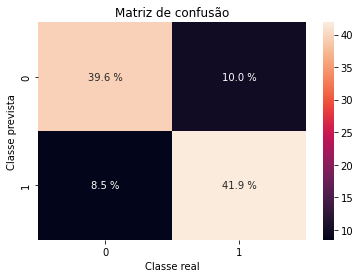

<Figure size 1440x1152 with 0 Axes>

In [53]:
ax = sns.heatmap(matrix,annot=True, fmt='.1f')
for t in ax.texts: t.set_text(t.get_text() + " %")

fig = plt.figure(figsize = (20,16))
ax.set_ylabel("Classe prevista")
ax.set_xlabel("Classe real")
ax.set_title("Matriz de confusão")

A matriz de confusão aponta como foi a distribuição de previsões do modelo treinado.